# Modelling Rogue Wave Data with Random Forest Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [2]:
import os
import pandas as pd
import numpy as np
import sys
import pickle

sys.path.append('./')
import utils

from collections import Counter
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score

import shap
from fgclustering import FgClustering

In [3]:
print(os.cpu_count()) # ask the question how many CPU cores are available on the current machine

8


In [4]:
seed = 42
n_jobs = 5

### Model Configuration

Select which case to use:

- case 1: class 0: target < 2.0 and class 1: target > 2.0 
- case 2: class 0: target < 1.5 and class 1: target > 2.0
- case 3: class 0: target < 1.5, class 1: 1.5 < target < 2.0 and class 2: target > 2.0

and if the data should be undersampled. In addition, set the number of cross-validation rounds.

In [5]:
case = 2
undersample = True

num_cv = 10

## Loading Rogue Wave Data

Loading the data that was preprocessed in `data_preprocessing.ipynb`.

In [ ]:
# Load and unpack the data
with open(f'./data/data_case{case}.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train = data[0]
X_test = data[1]
y_train = data[2]
y_test = data[3]

To tackle the high class imbalance we will undersample the larger class using NearMiss Undersampler. Near-miss is an algorithm that can help in balancing an imbalanced dataset. It can be grouped under undersampling algorithms and is an efficient way to balance the data. The algorithm does this by looking at the class distribution and randomly eliminating samples from the larger class. When two points belonging to different classes are very close to each other in the distribution, this algorithm eliminates the datapoint of the larger class thereby trying to balance the distribution.

For expl of version argument and n_neighbours see https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145

In [ ]:
if undersample:
    X_train_original = X_train

    nm = NearMiss(version=1, sampling_strategy='auto', n_neighbors=5) 
    X_train, y_train = nm.fit_resample(X_train, y_train)    

    print('Resampled dataset shape:')
    print(Counter(y_train))

    utils.plot_distributions_target(pd.DataFrame({"target_original": X_train_original["AI_10min"]}), pd.DataFrame({"target_undersampled": X_train["AI_10min"]}))

After undersampling, drop the continuous target variable from the dataset as we only use the binarized version for classification.

In [ ]:
X_train = X_train.drop(columns=['AI_10min'])
X_test = X_test.drop(columns=['AI_10min'])

We don't need to scale the features for Random Forest models.

## Building a Random Forest Classification Model

### Setting Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
- `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.
- `max_features`: The number of features to consider when looking for the best split.
- `class weight`:
  - The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
  - The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [11]:
hyperparameter_grid = {'n_estimators': [250, 750, 1500], 
            'max_depth': [5, 10, 20, 30], 
            'max_samples': [0.5, 0.8, 0.95],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2'],
            'class_weight': ['balanced', 'balanced_subsample'] 
}

### Train the Model

In [19]:
# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=seed)

In [20]:
# Tune hyperparameters
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train)

gridsearch_classifier = GridSearchCV(classifier, hyperparameter_grid, cv=skf, verbose=2, n_jobs=n_jobs)
gridsearch_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   4.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   4.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   4.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   4.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   4.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   3.8s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, max_samples=0.5, n_estimators=250; total time=   3.

GridSearchCV(cv=<generator object _BaseKFold.split at 0x13e59a560>,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=5,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.5, 0.8, 0.95],
                         'n_estimators': [250, 750, 1500]},
             verbose=2)

### Evaulate the Model

For evaluation use confusion matrix, macro F1 score and balanced accuracy to account for class imbalances.

In [21]:
# Check the results
print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_*100, 2)}% accuracy and the parameters of best prediction model are:')
print(gridsearch_classifier.best_params_)

The mean cross-validated score of the best model is 96.61% accuracy and the parameters of best prediction model are:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 750}


In [22]:
# Take the best estimator
model = gridsearch_classifier.best_estimator_

# Predict labels
y_pred = model.predict(X_test)

In [23]:
print(f"Balanced acc: {balanced_accuracy_score(y_test, y_pred)}")
print(f"Macro F1 score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

Balanced acc: 0.8102563455213629
Macro F1 score: 0.4764721849498938
Confusion matrix:
[[52283 31445]
 [   14  3552]]


### Save the Model

In [24]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, model]

with open(f'./models/model_randomforest_case{case}_unders_{undersample}.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load the Model

In [26]:
# Load and unpack the data
with open(f'./models/model_randomforest_case{case}_unders_{undersample}.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
rf = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, rf.predict(X_train))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, rf.predict(X_test))*100,2)} % balanced accuracy.')

Model Performance on training data: 100.0 % balanced accuracy.
Model Performance on test data: 81.03 % balanced accuracy.


## Explainability for Random Forest Model

### Random Forest Feature Importance

An alternative to Permutation Feature Importance is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute feature_importances_ .

Lets plot the feature importance based on mean decrease in impurity:

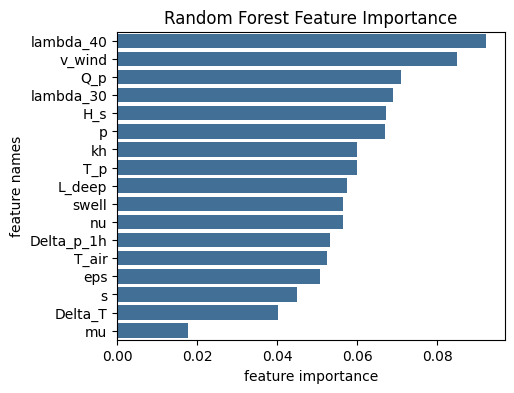

In [27]:
utils.plot_impurity_feature_importance(rf.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance")

### Interpretation with SHAP

With SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this GitHub thread:

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we provide a background dataset for integrating out features. This dataset has to be passed to an Independent masker, which correctly subsamles the data (otherwise only the first 100 samples are subsampled and the expected value might show high variations).

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for model_output="raw", which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the model_output="probability" explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model.


In [ ]:
# run SHAP
explainer = shap.TreeExplainer(model=rf, data=shap.maskers.Independent(X_train, max_samples=100), model_output="probability")
shap_values = explainer(X_train)

# get original unscaled feature values
shap_values.data = X_train.round(4)

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

### Interpretation with Forest-Guided Clustering

In [28]:
data_fgc = X_train.copy()
data_fgc["target"] = y_train

Run FGC with subsampling

In [ ]:
number_of_iterations = 50   # Number of times dataset will be subsampled
sample_size = 5000           # Number of samples in the subsampled dataset
max_K = 10                   # Maximum K for the FGC

k_result =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

for i in range(number_of_iterations):
    # sample the dataset
    data_sample = data_fgc.sample(
        n = sample_size, replace = False, random_state = i
        ) # setting random state for reproducibility
    # instantiate the fgc object on the subsampled dataset and run it:
    fgc = FgClustering(
        model=rf, data=data_sample, target_column='target'
        )
    fgc.run(
        method_clustering = 'pam', max_K = max_K, 
        discart_value_JI = 0.60, bootstraps_JI = 100, n_jobs = n_jobs, verbose = 0
        )
    # save the result
    k_result[fgc.k] += 1

    print(f"For round {i} the opt k is {fgc.k}")

pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

In [32]:
pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

,k,count
0,2,11
1,1,2
2,5,1
3,9,1
4,6,1
5,4,0
6,3,0
7,7,0
8,8,0


Interpreting RandomForestClassifier
Use 2 as number of cluster


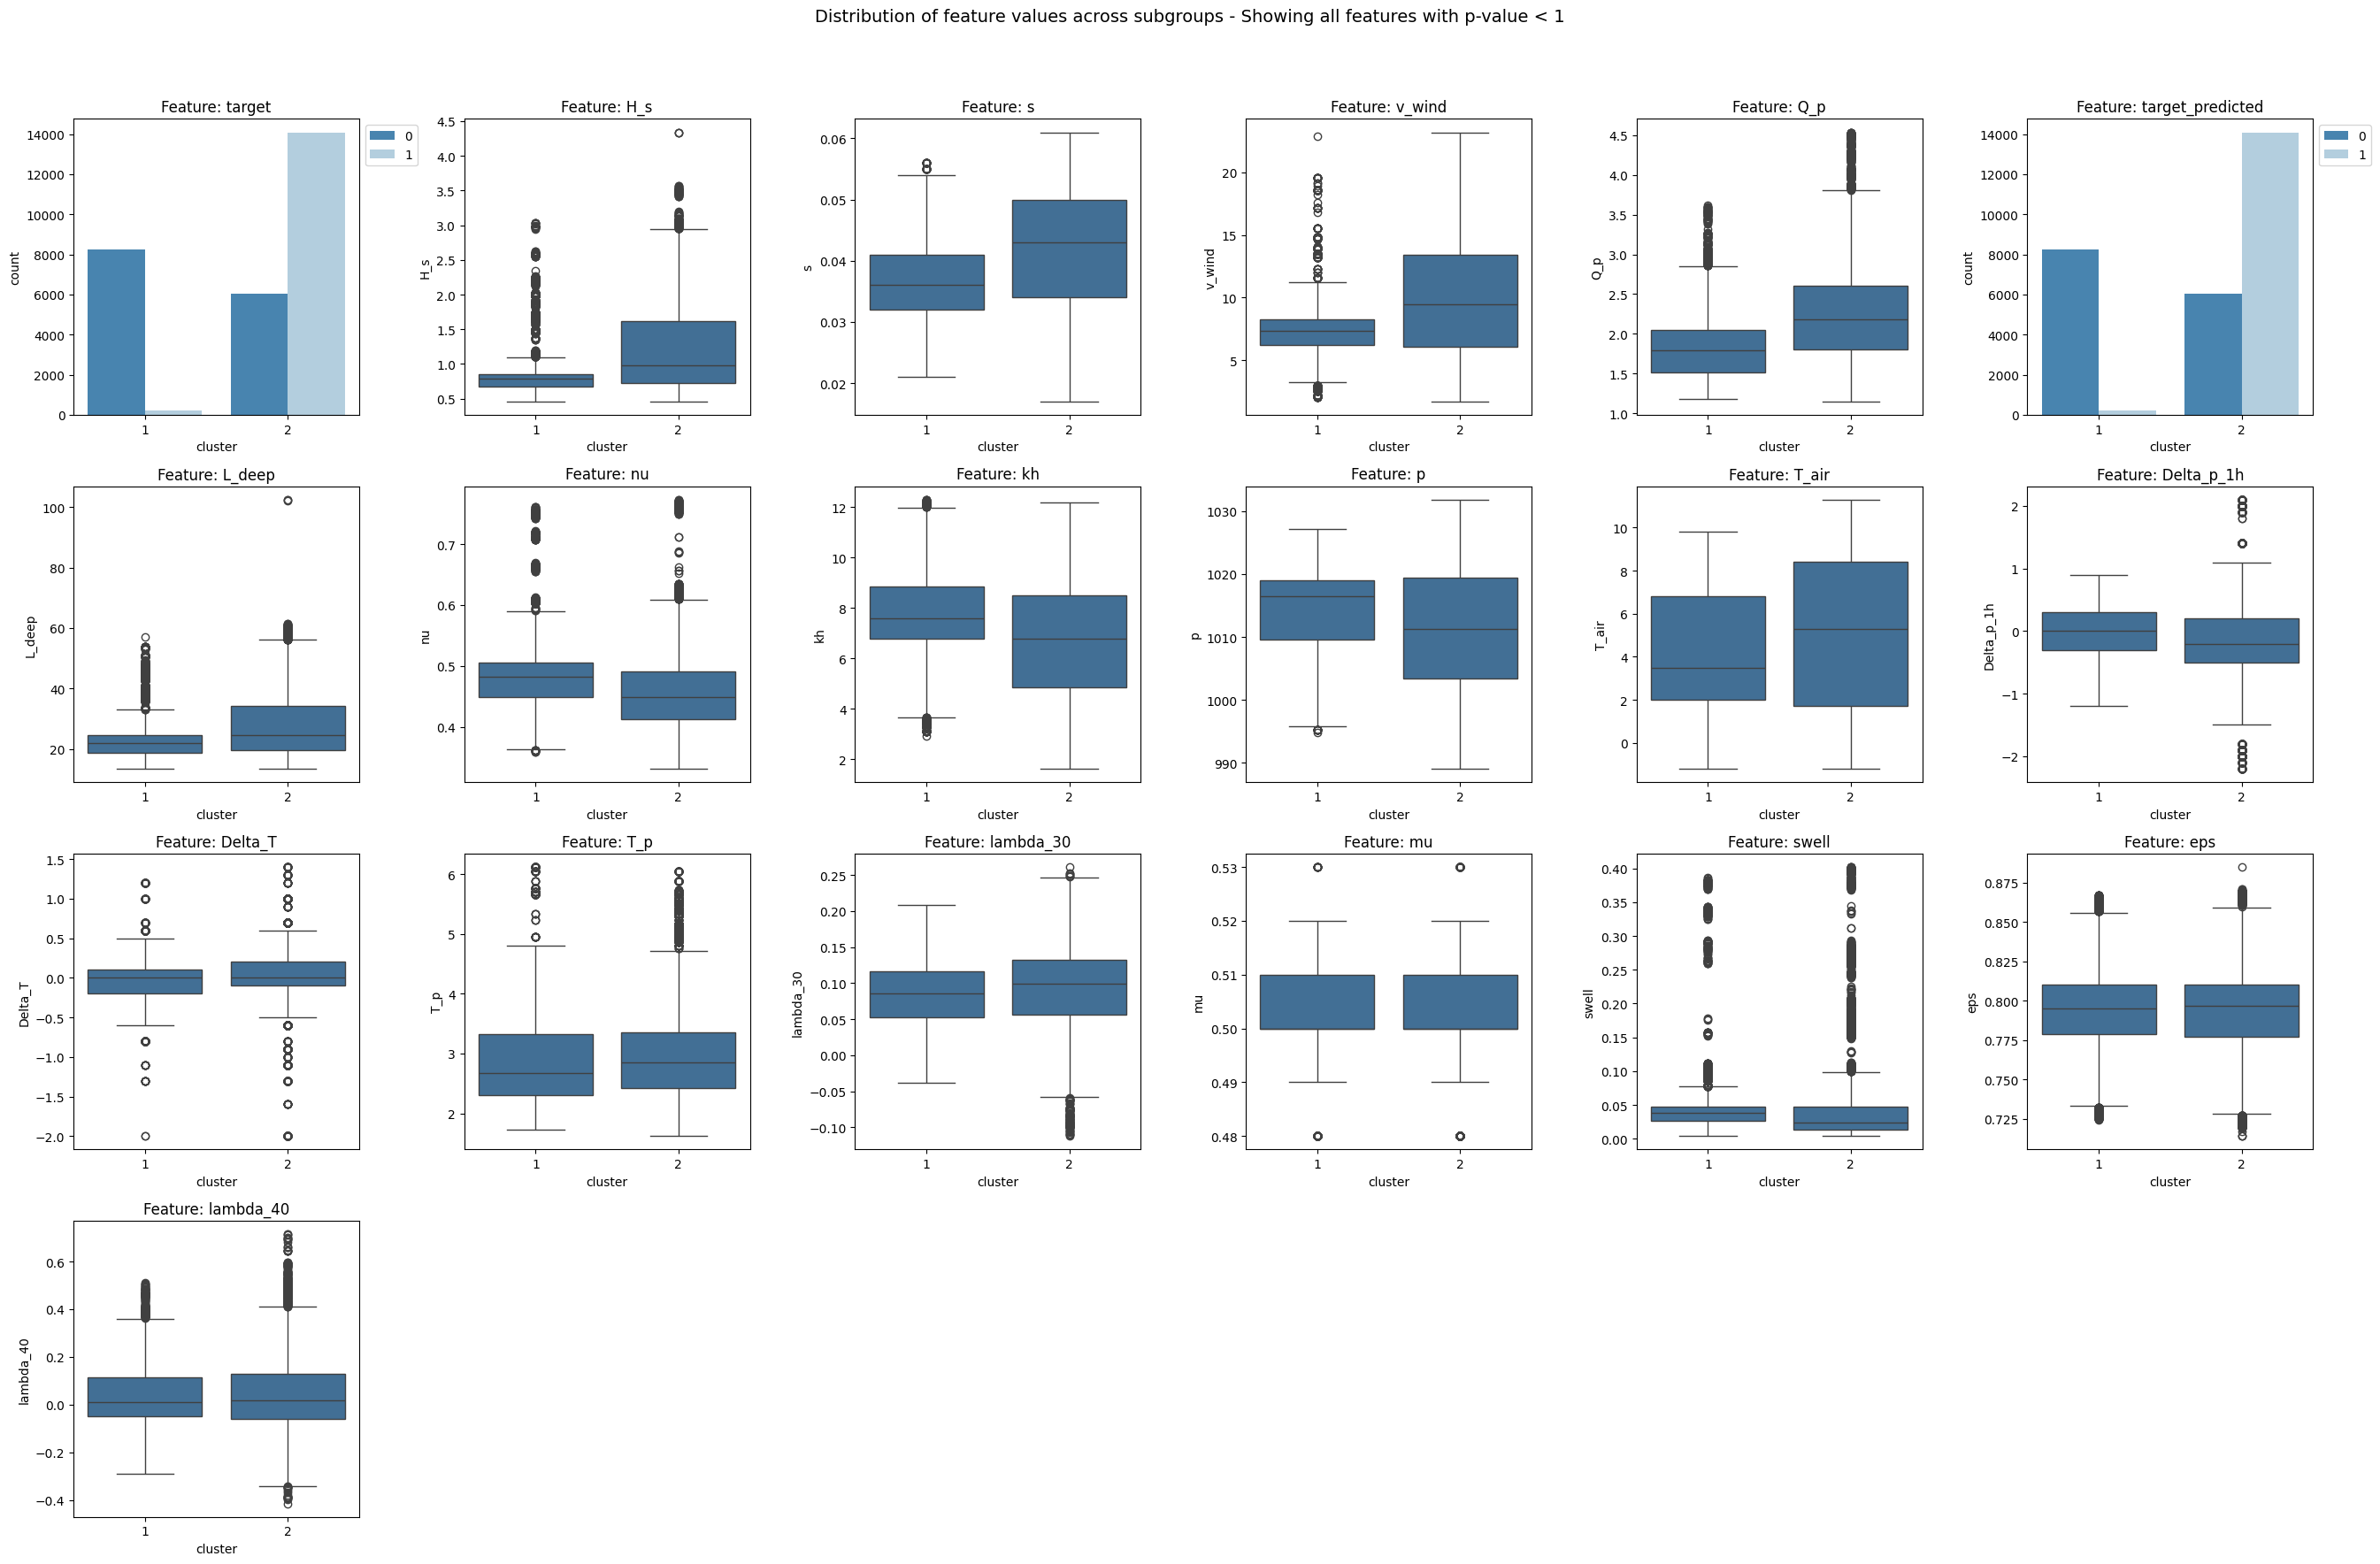

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


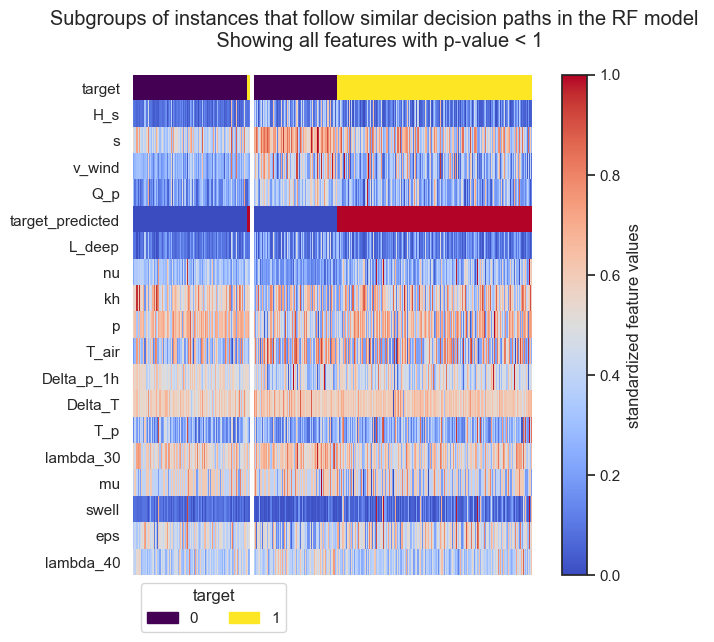

Use 3 as number of cluster


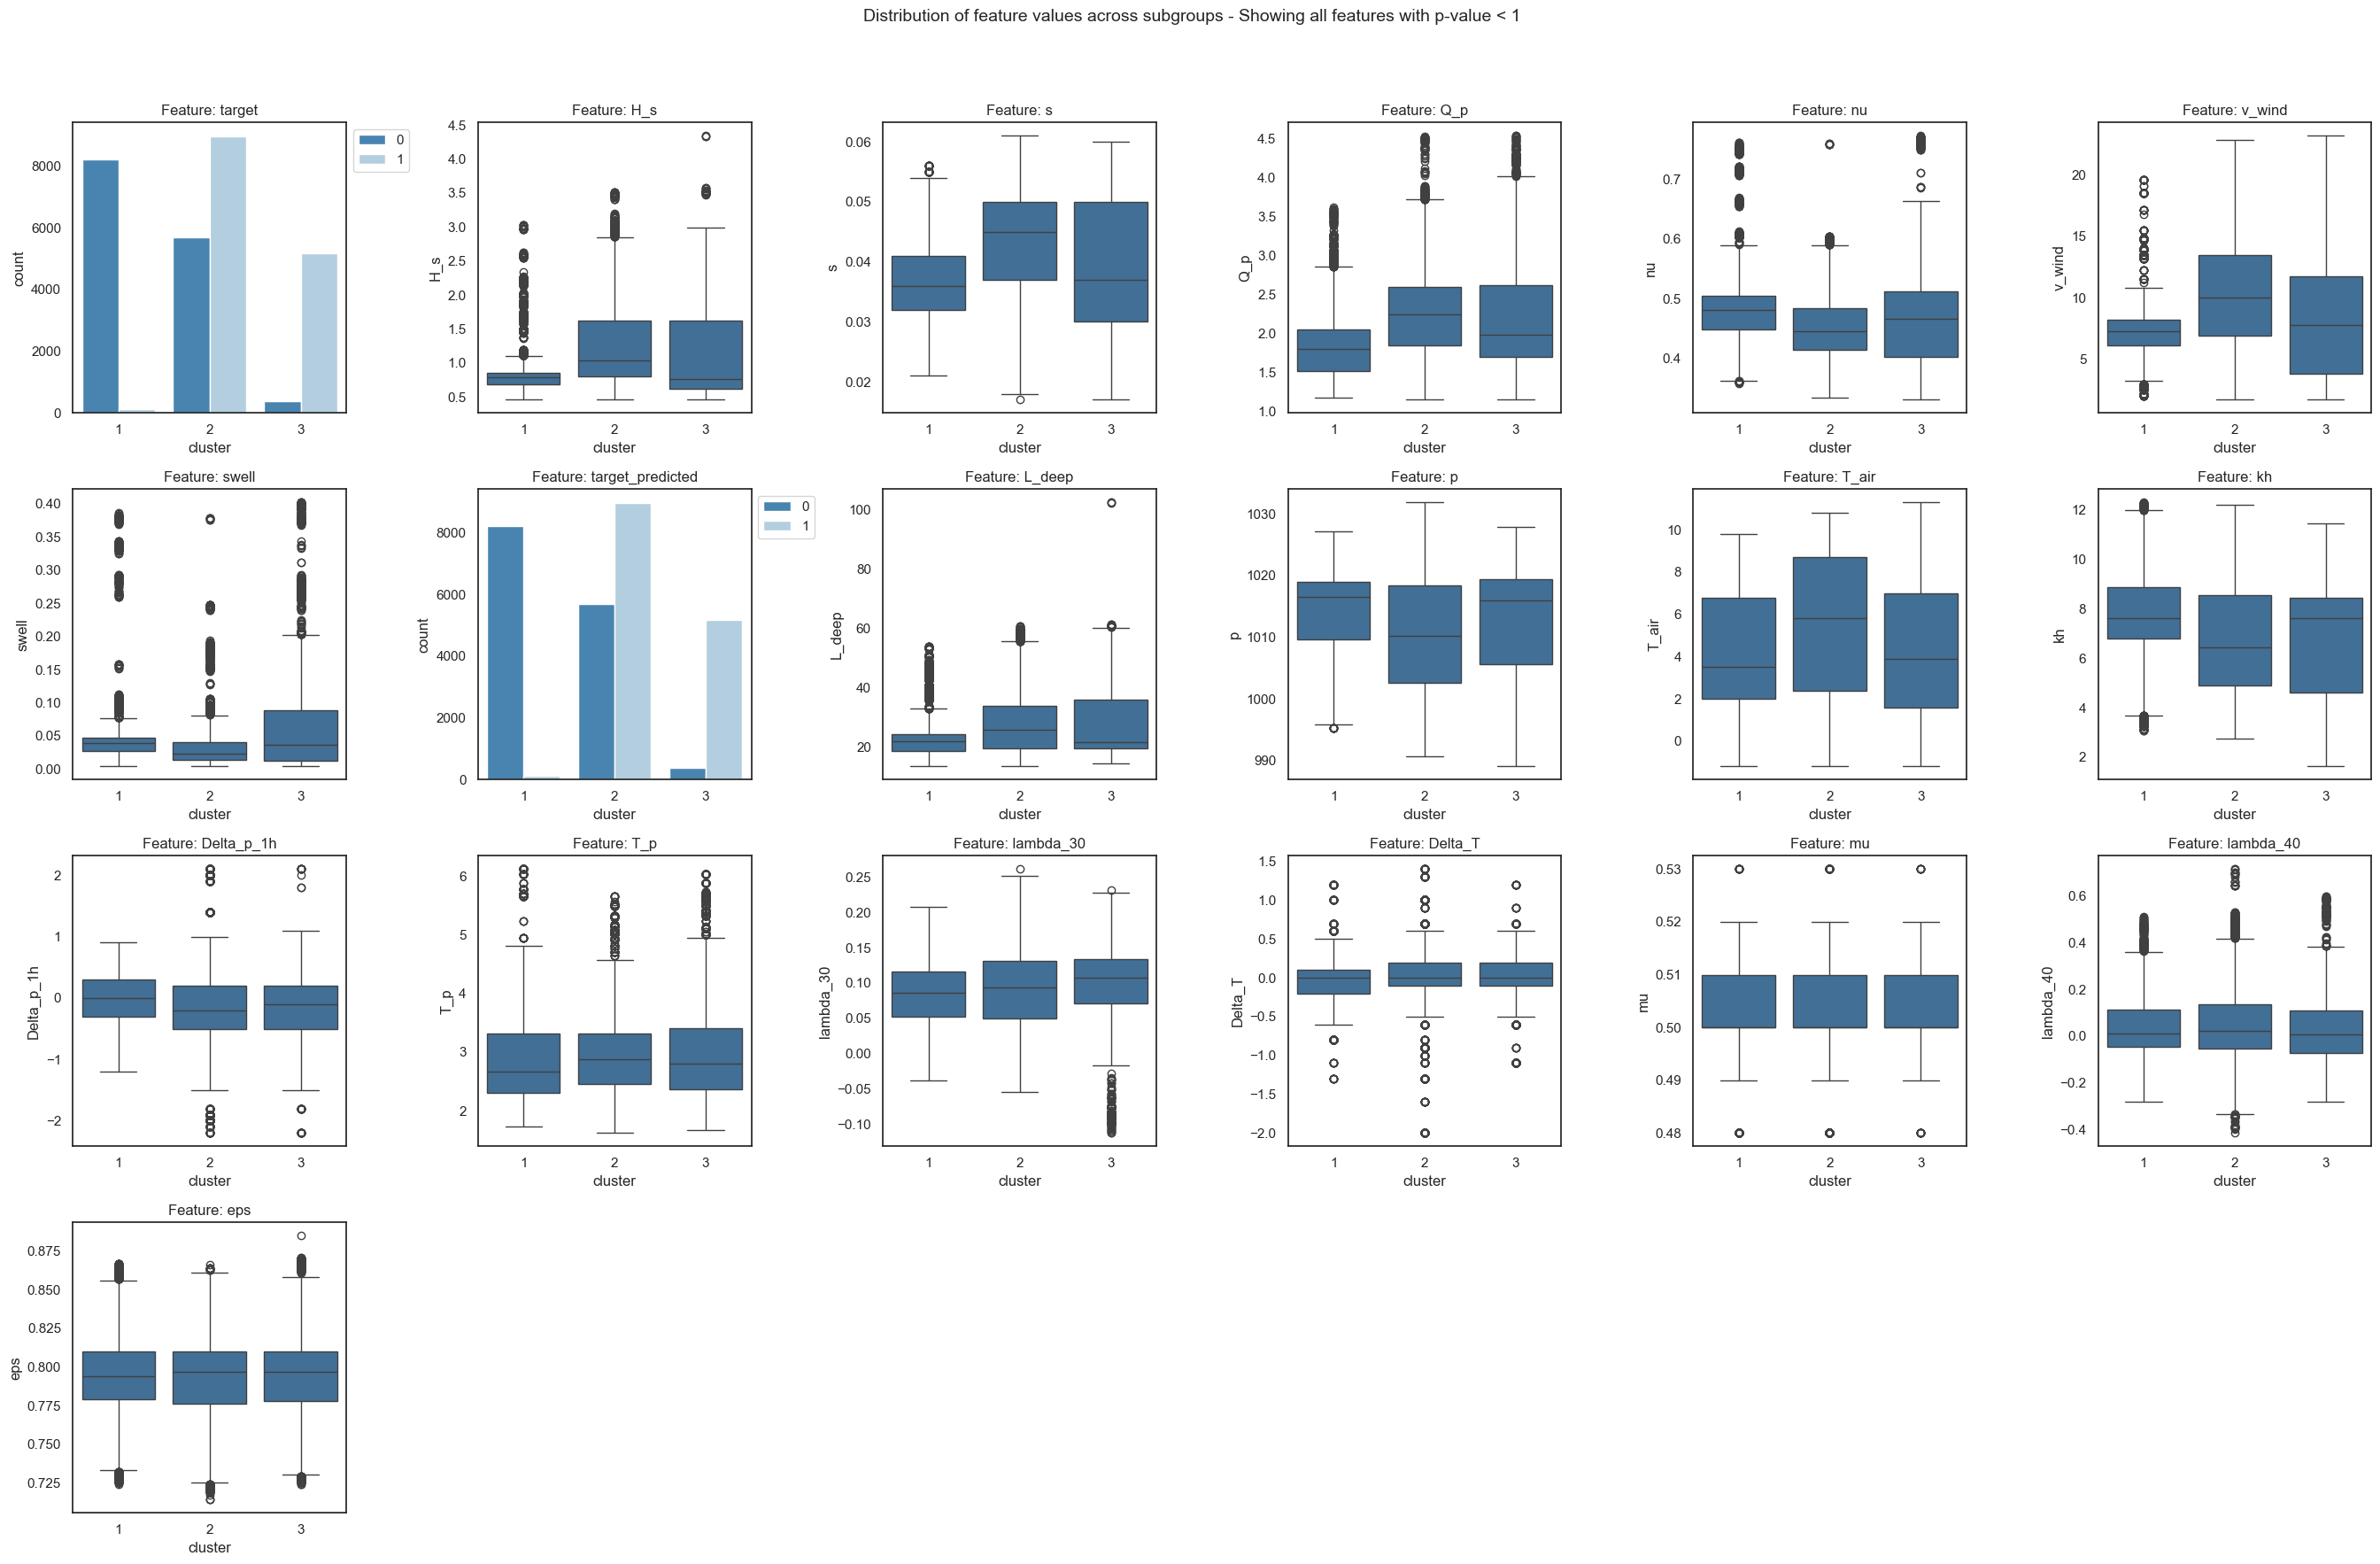

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


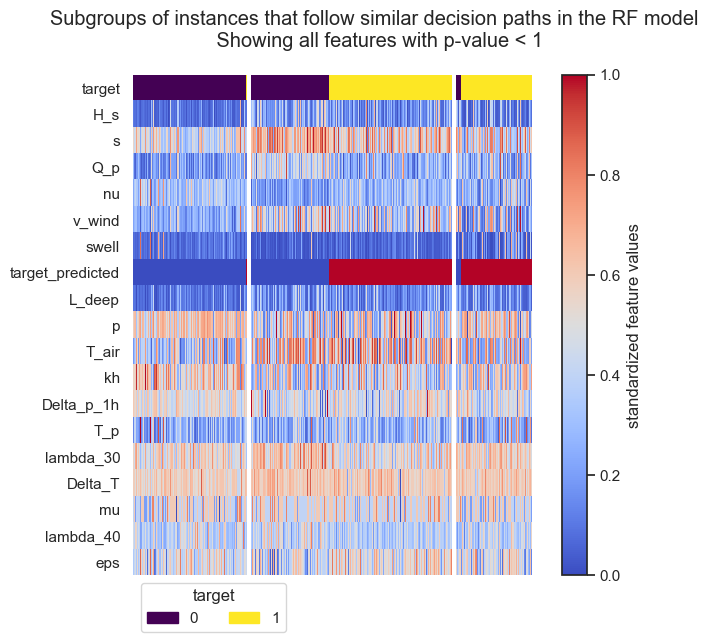

Use 4 as number of cluster


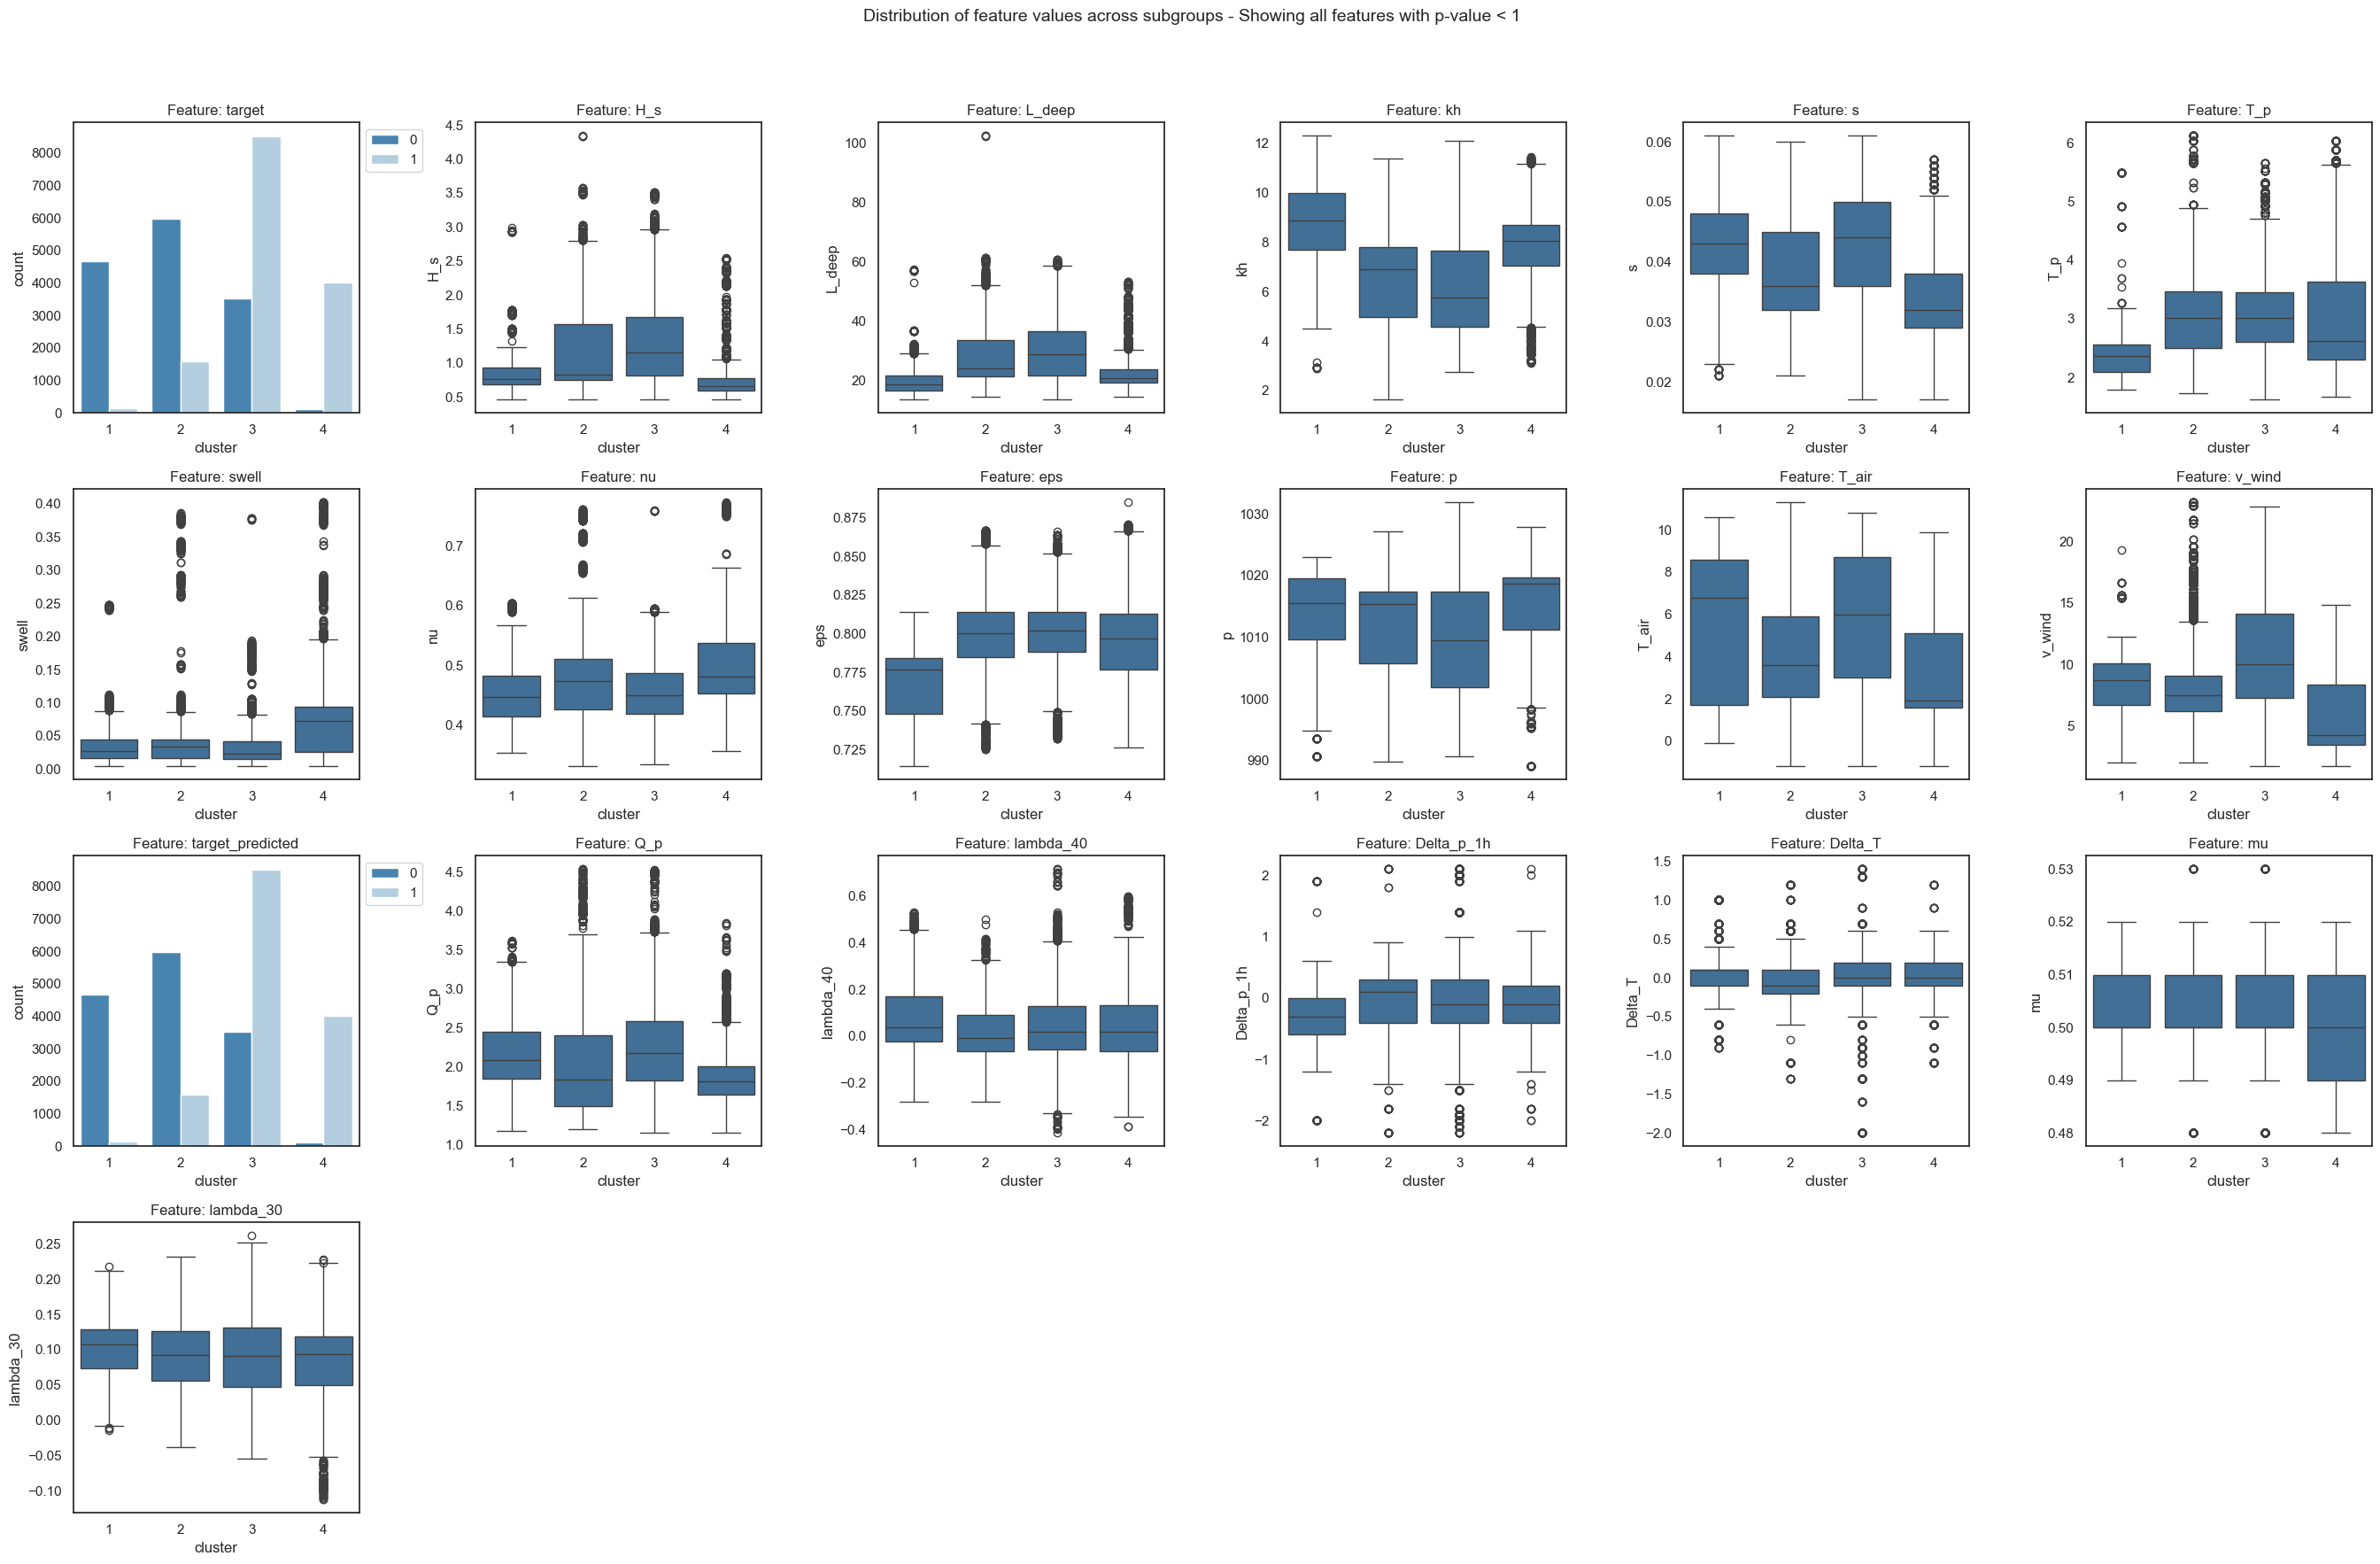

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


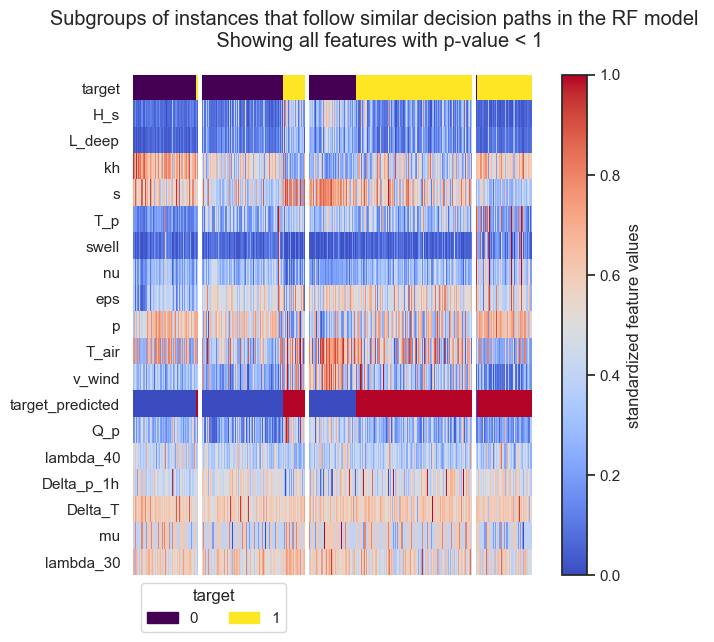

Use 5 as number of cluster


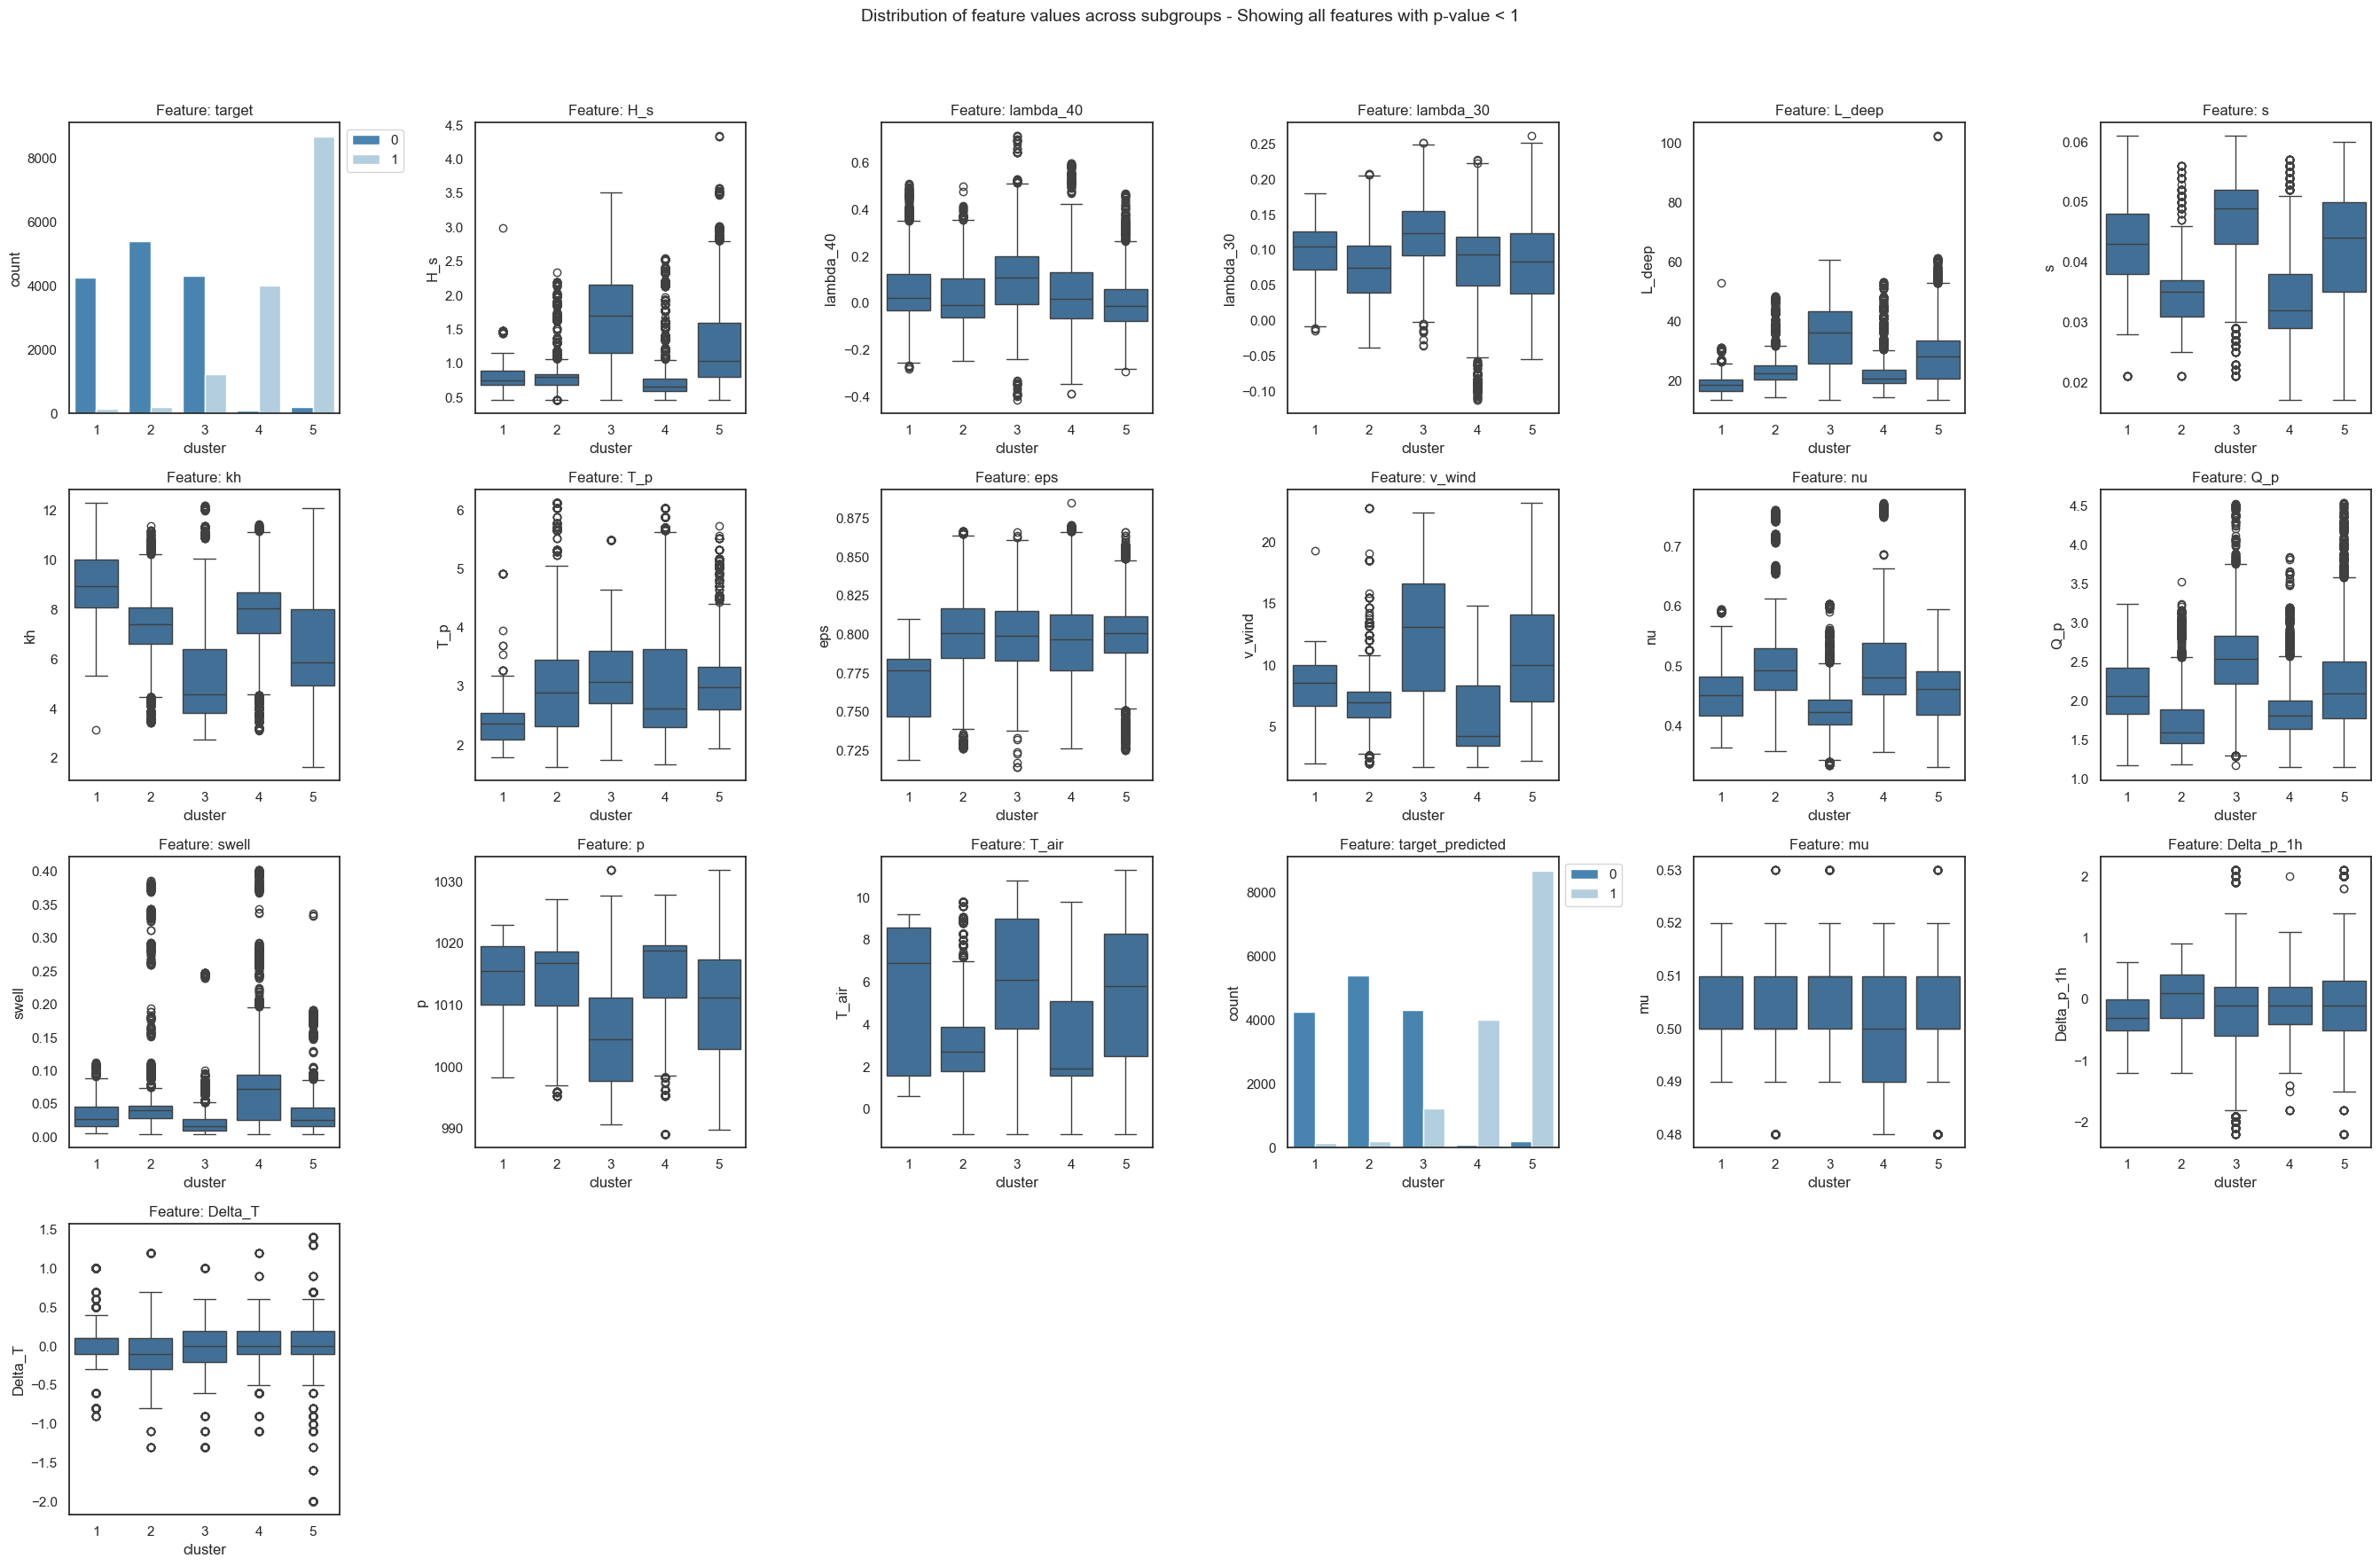

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


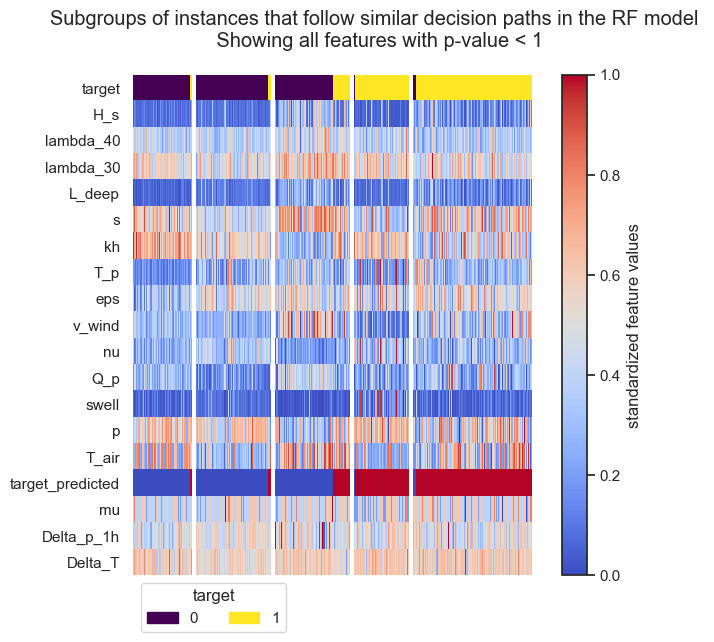

Use 6 as number of cluster


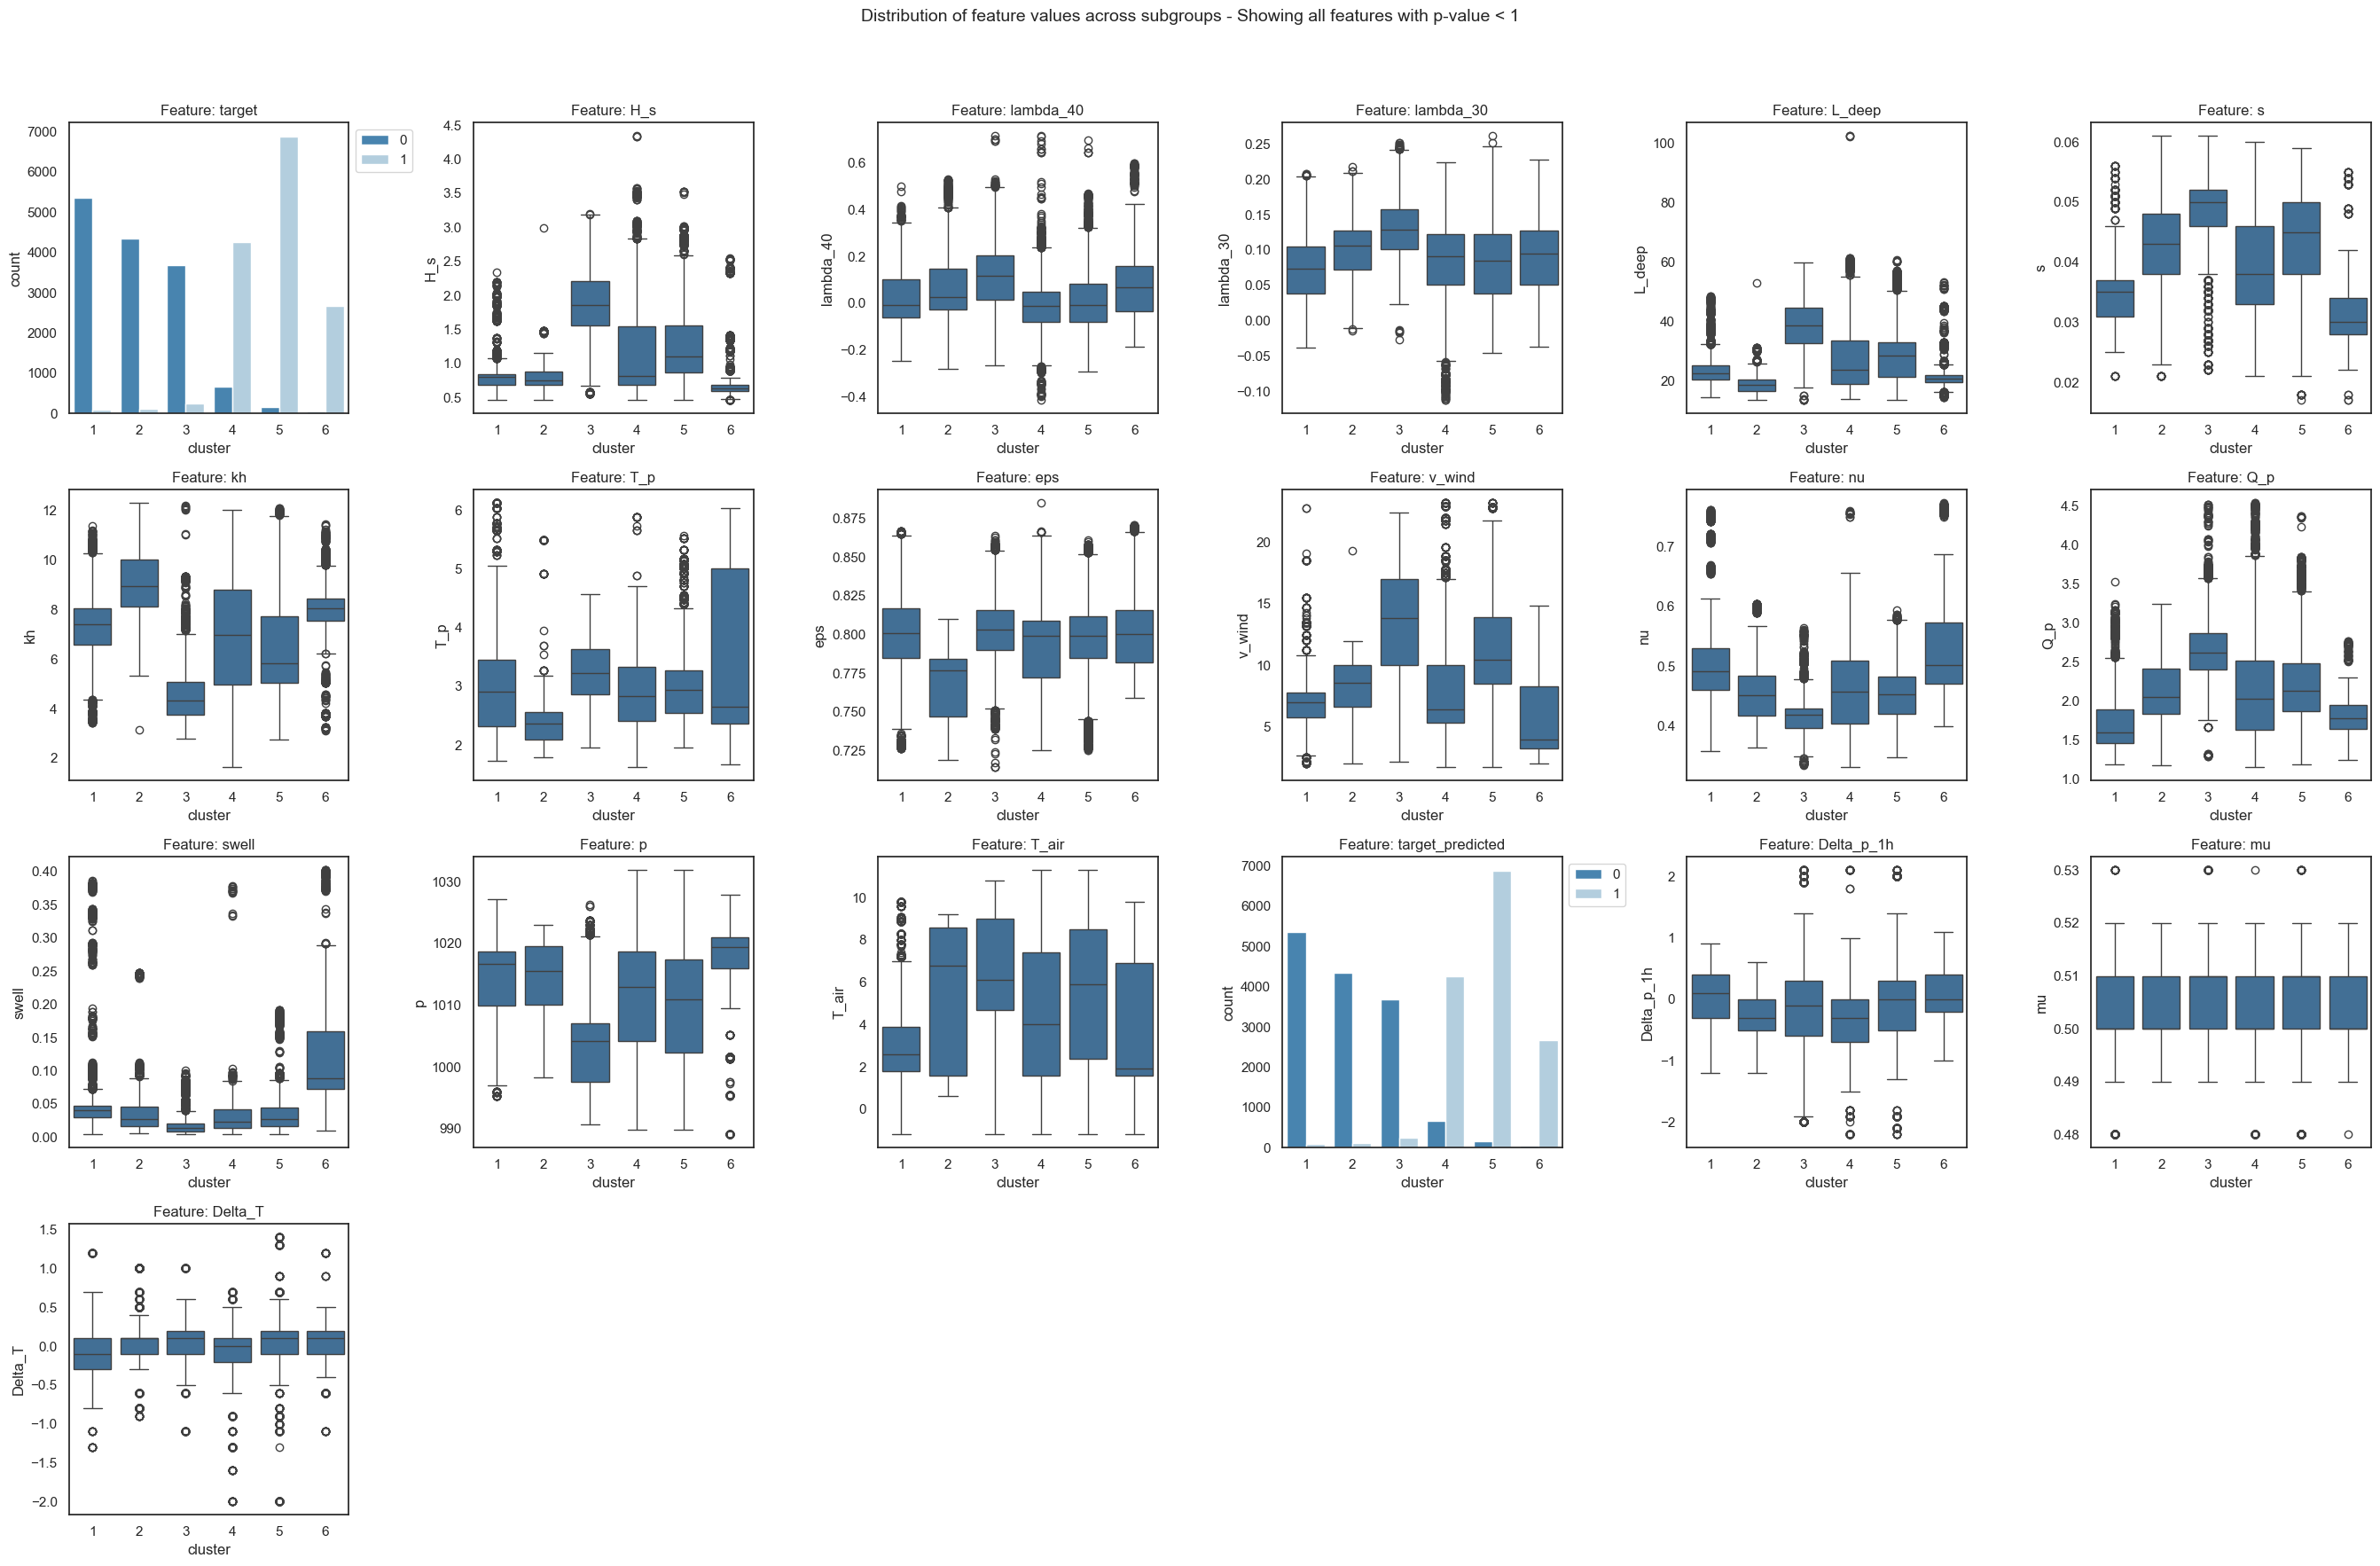

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


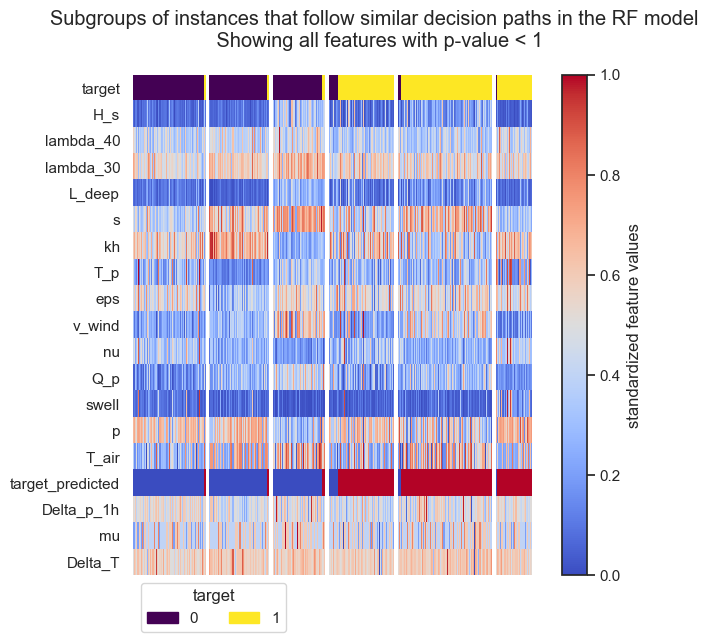

Use 7 as number of cluster


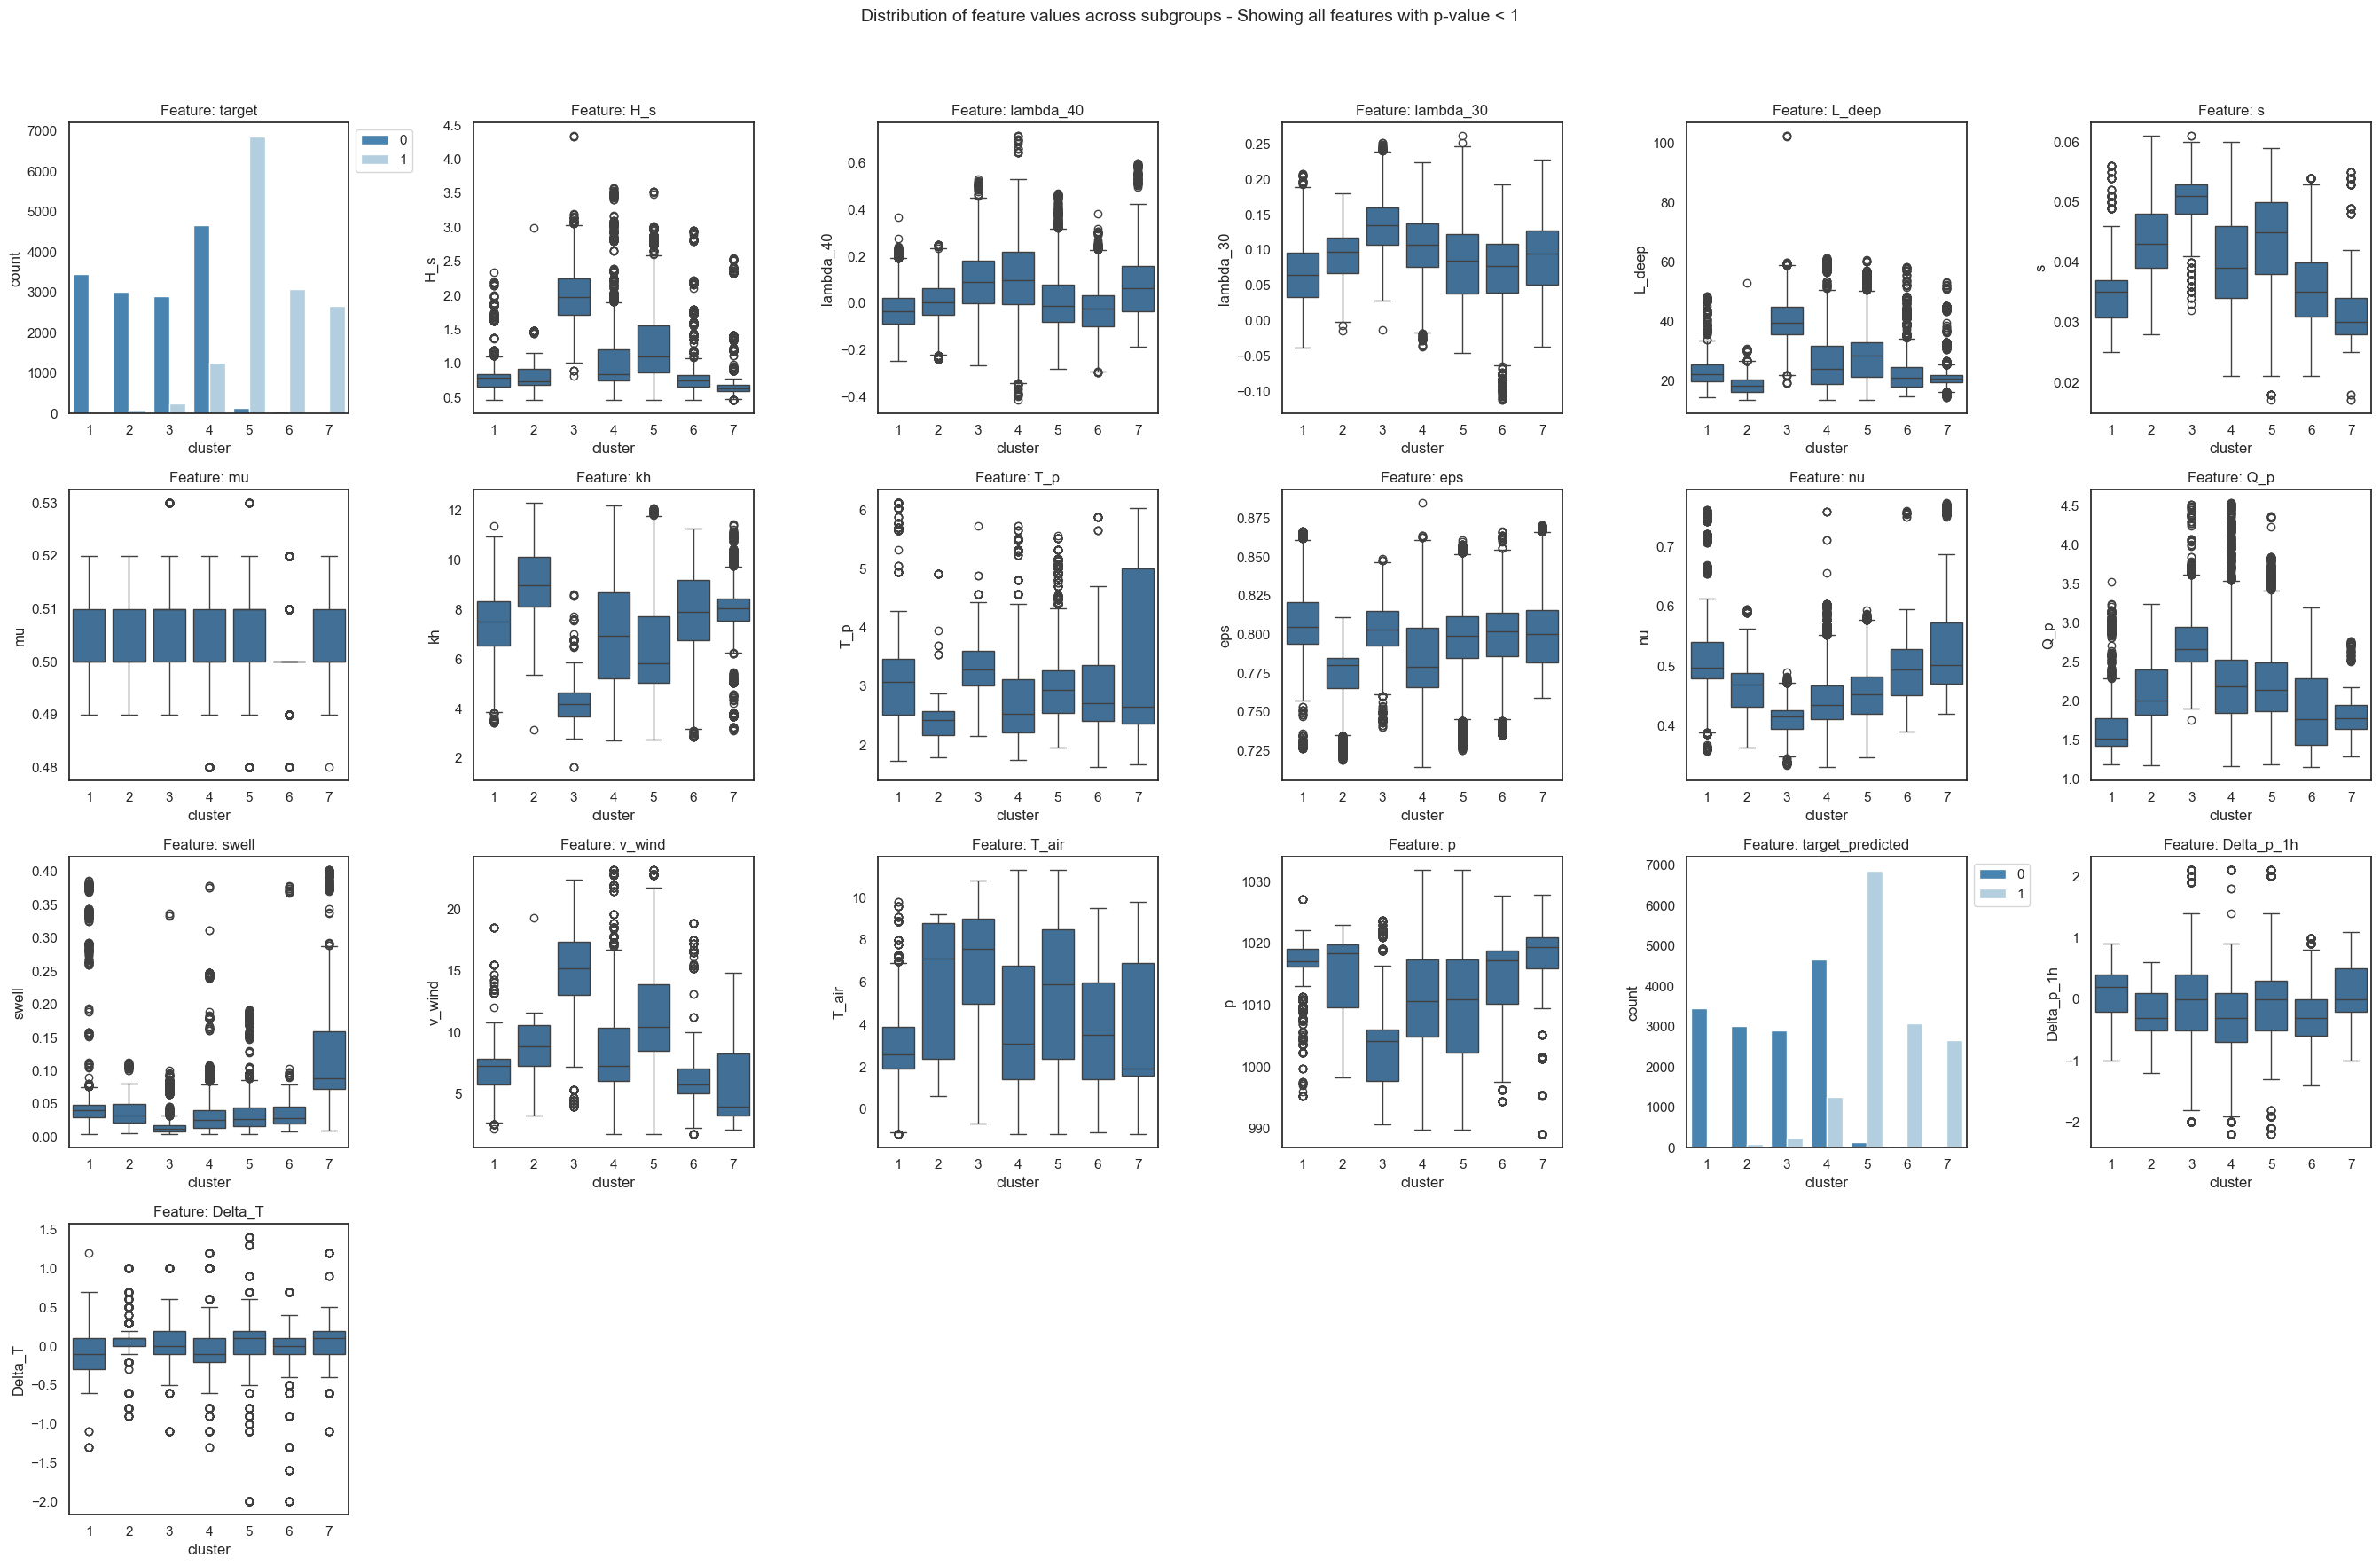

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


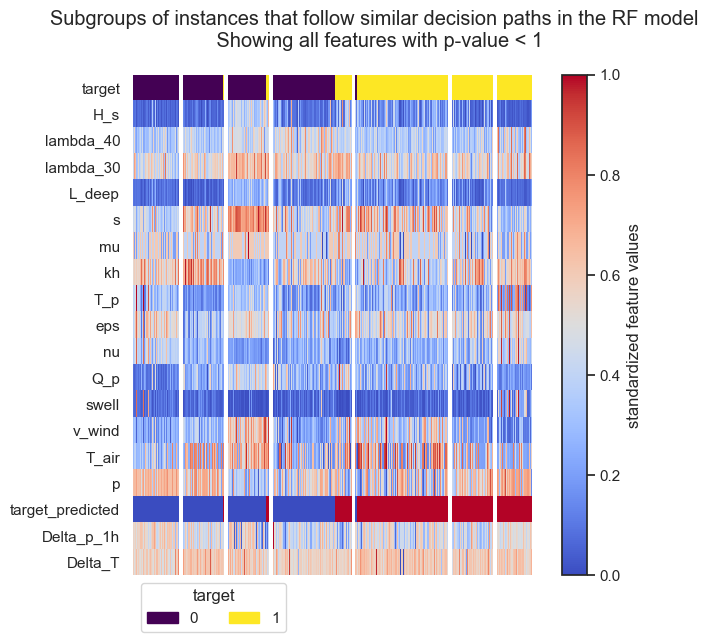

Use 8 as number of cluster


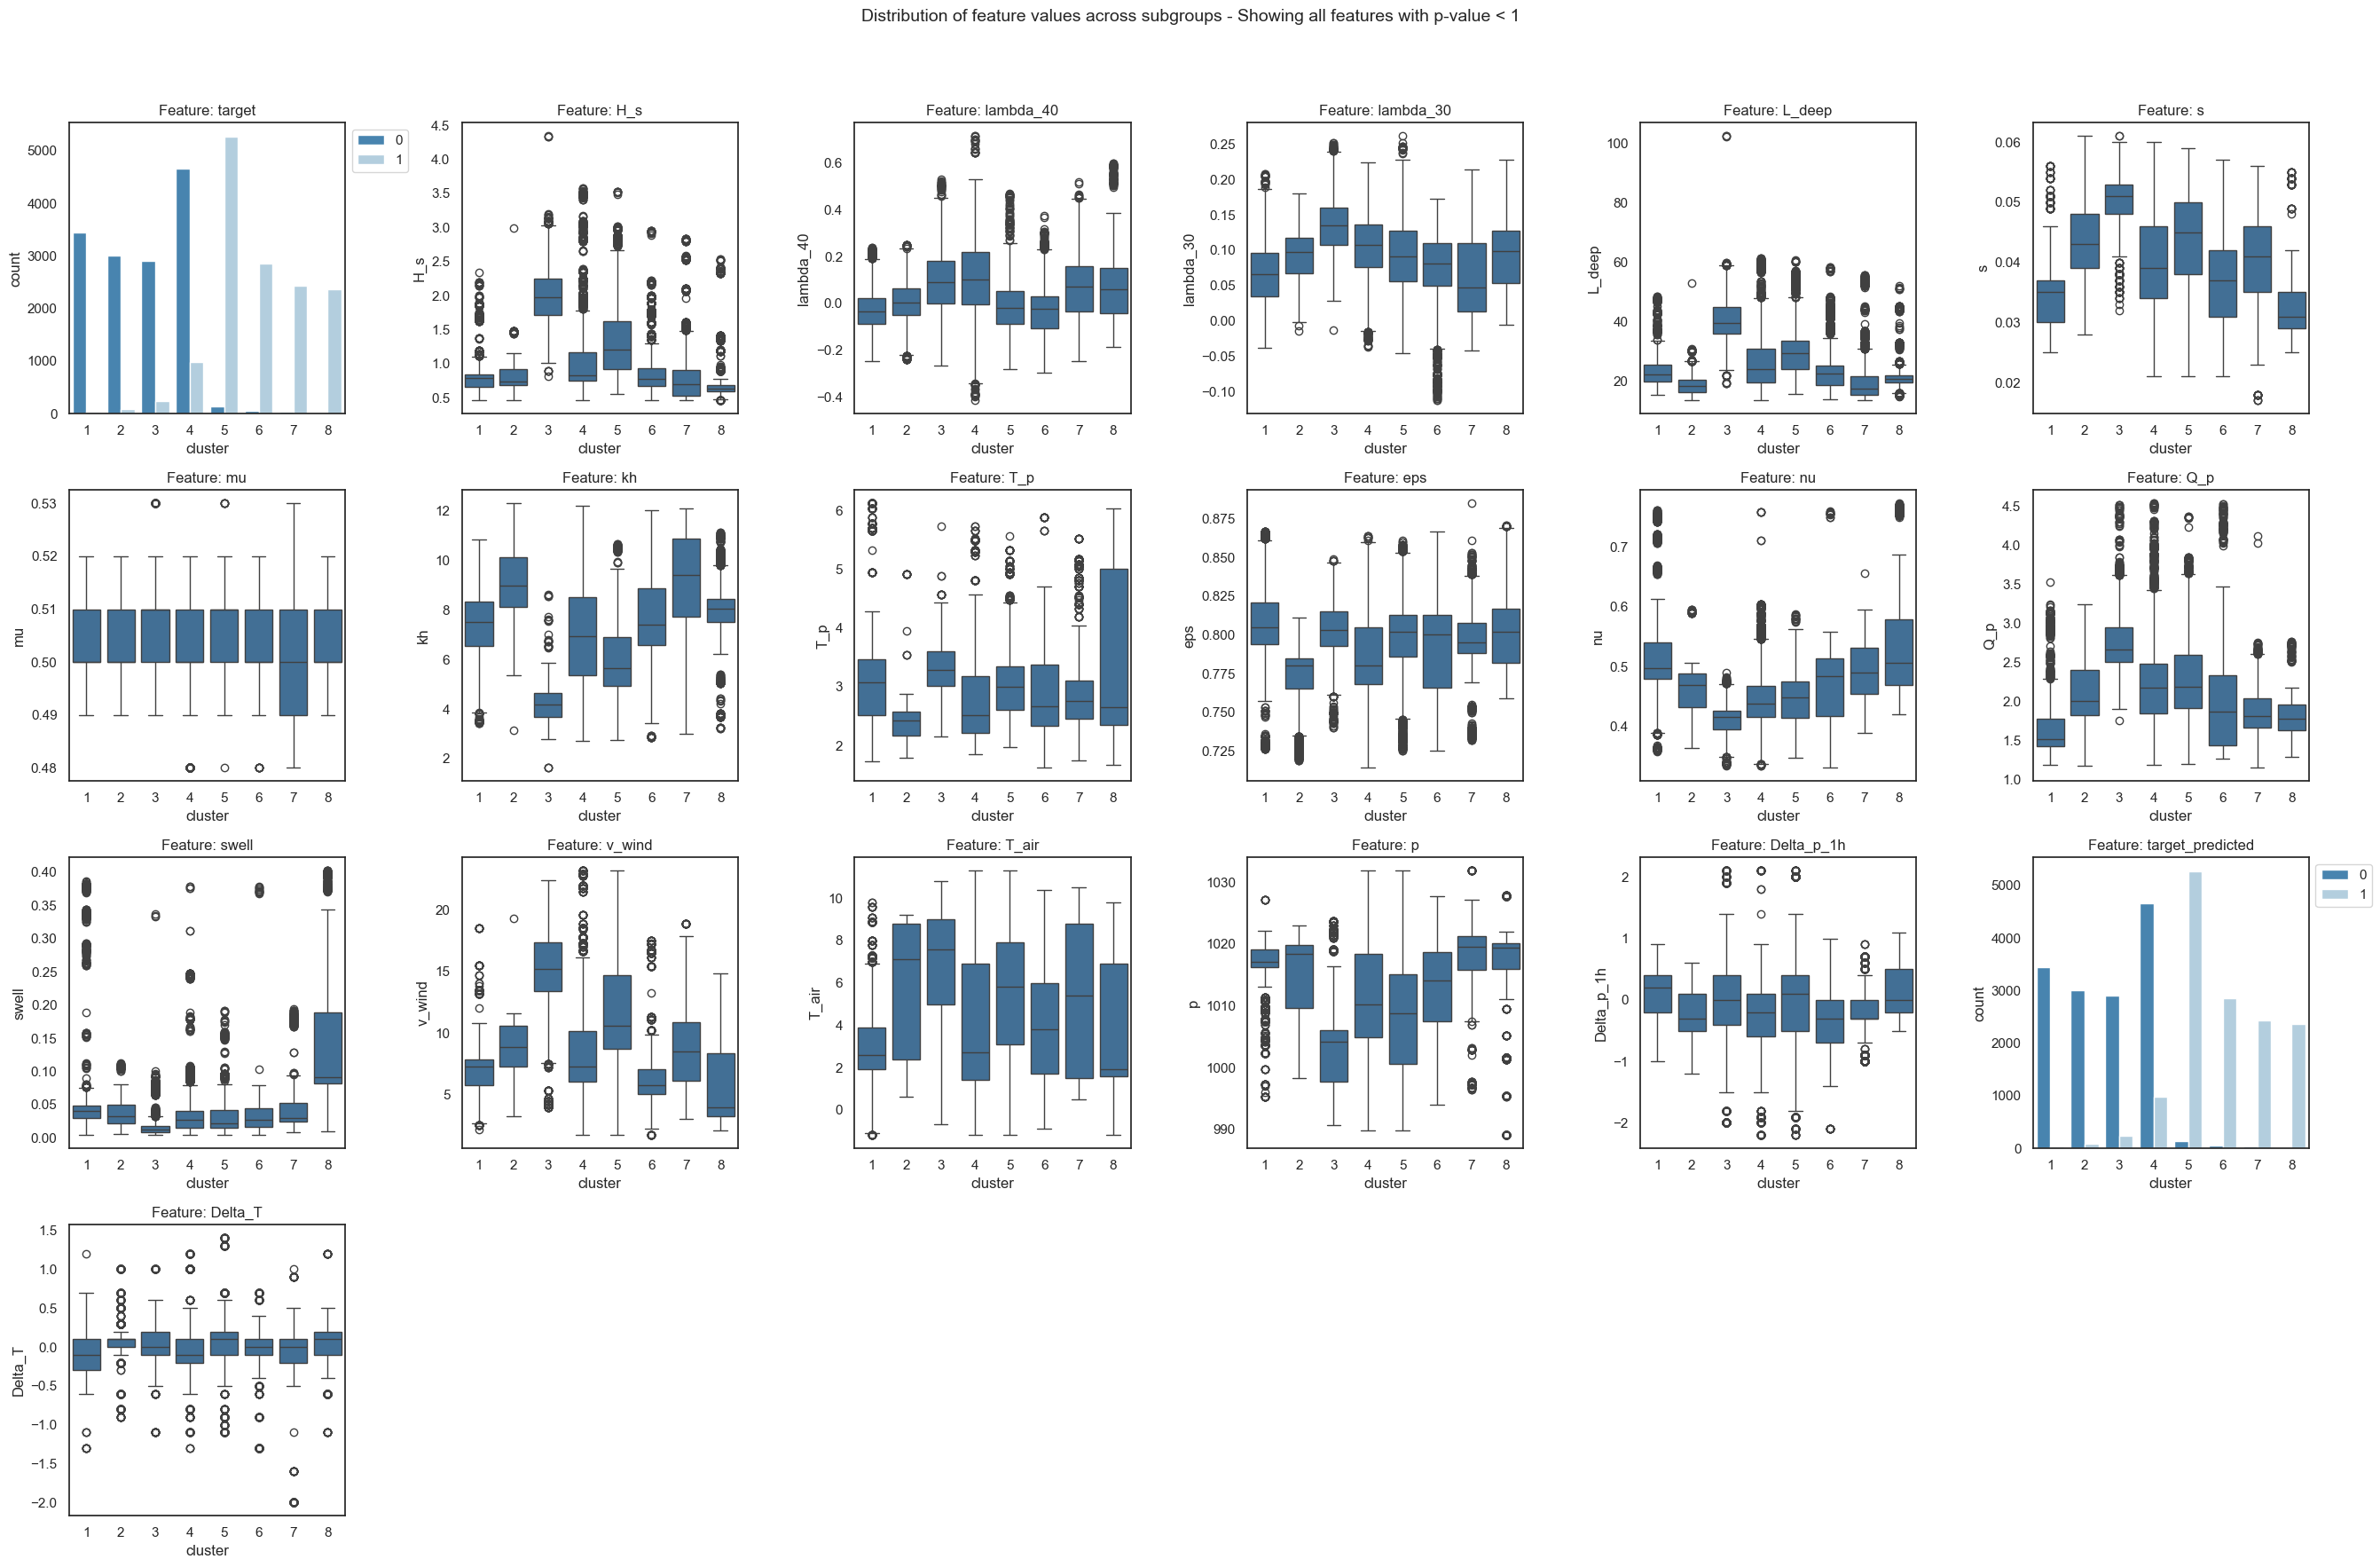

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


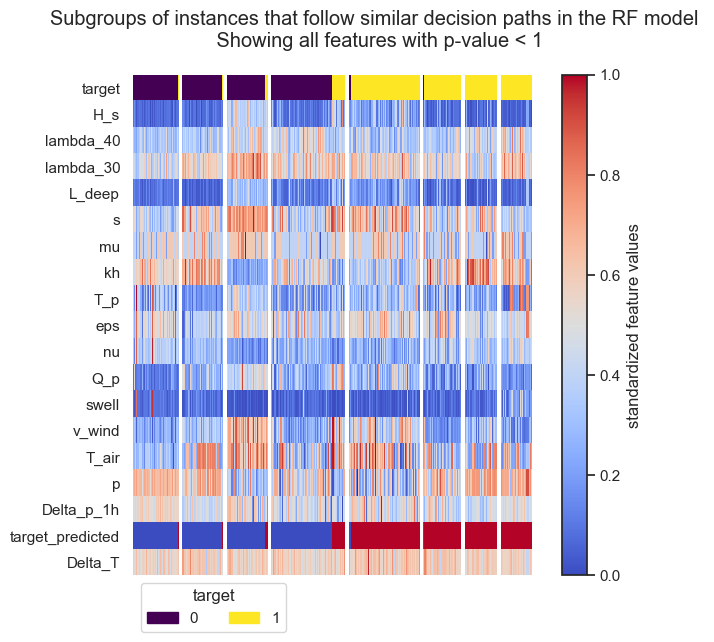

Use 9 as number of cluster


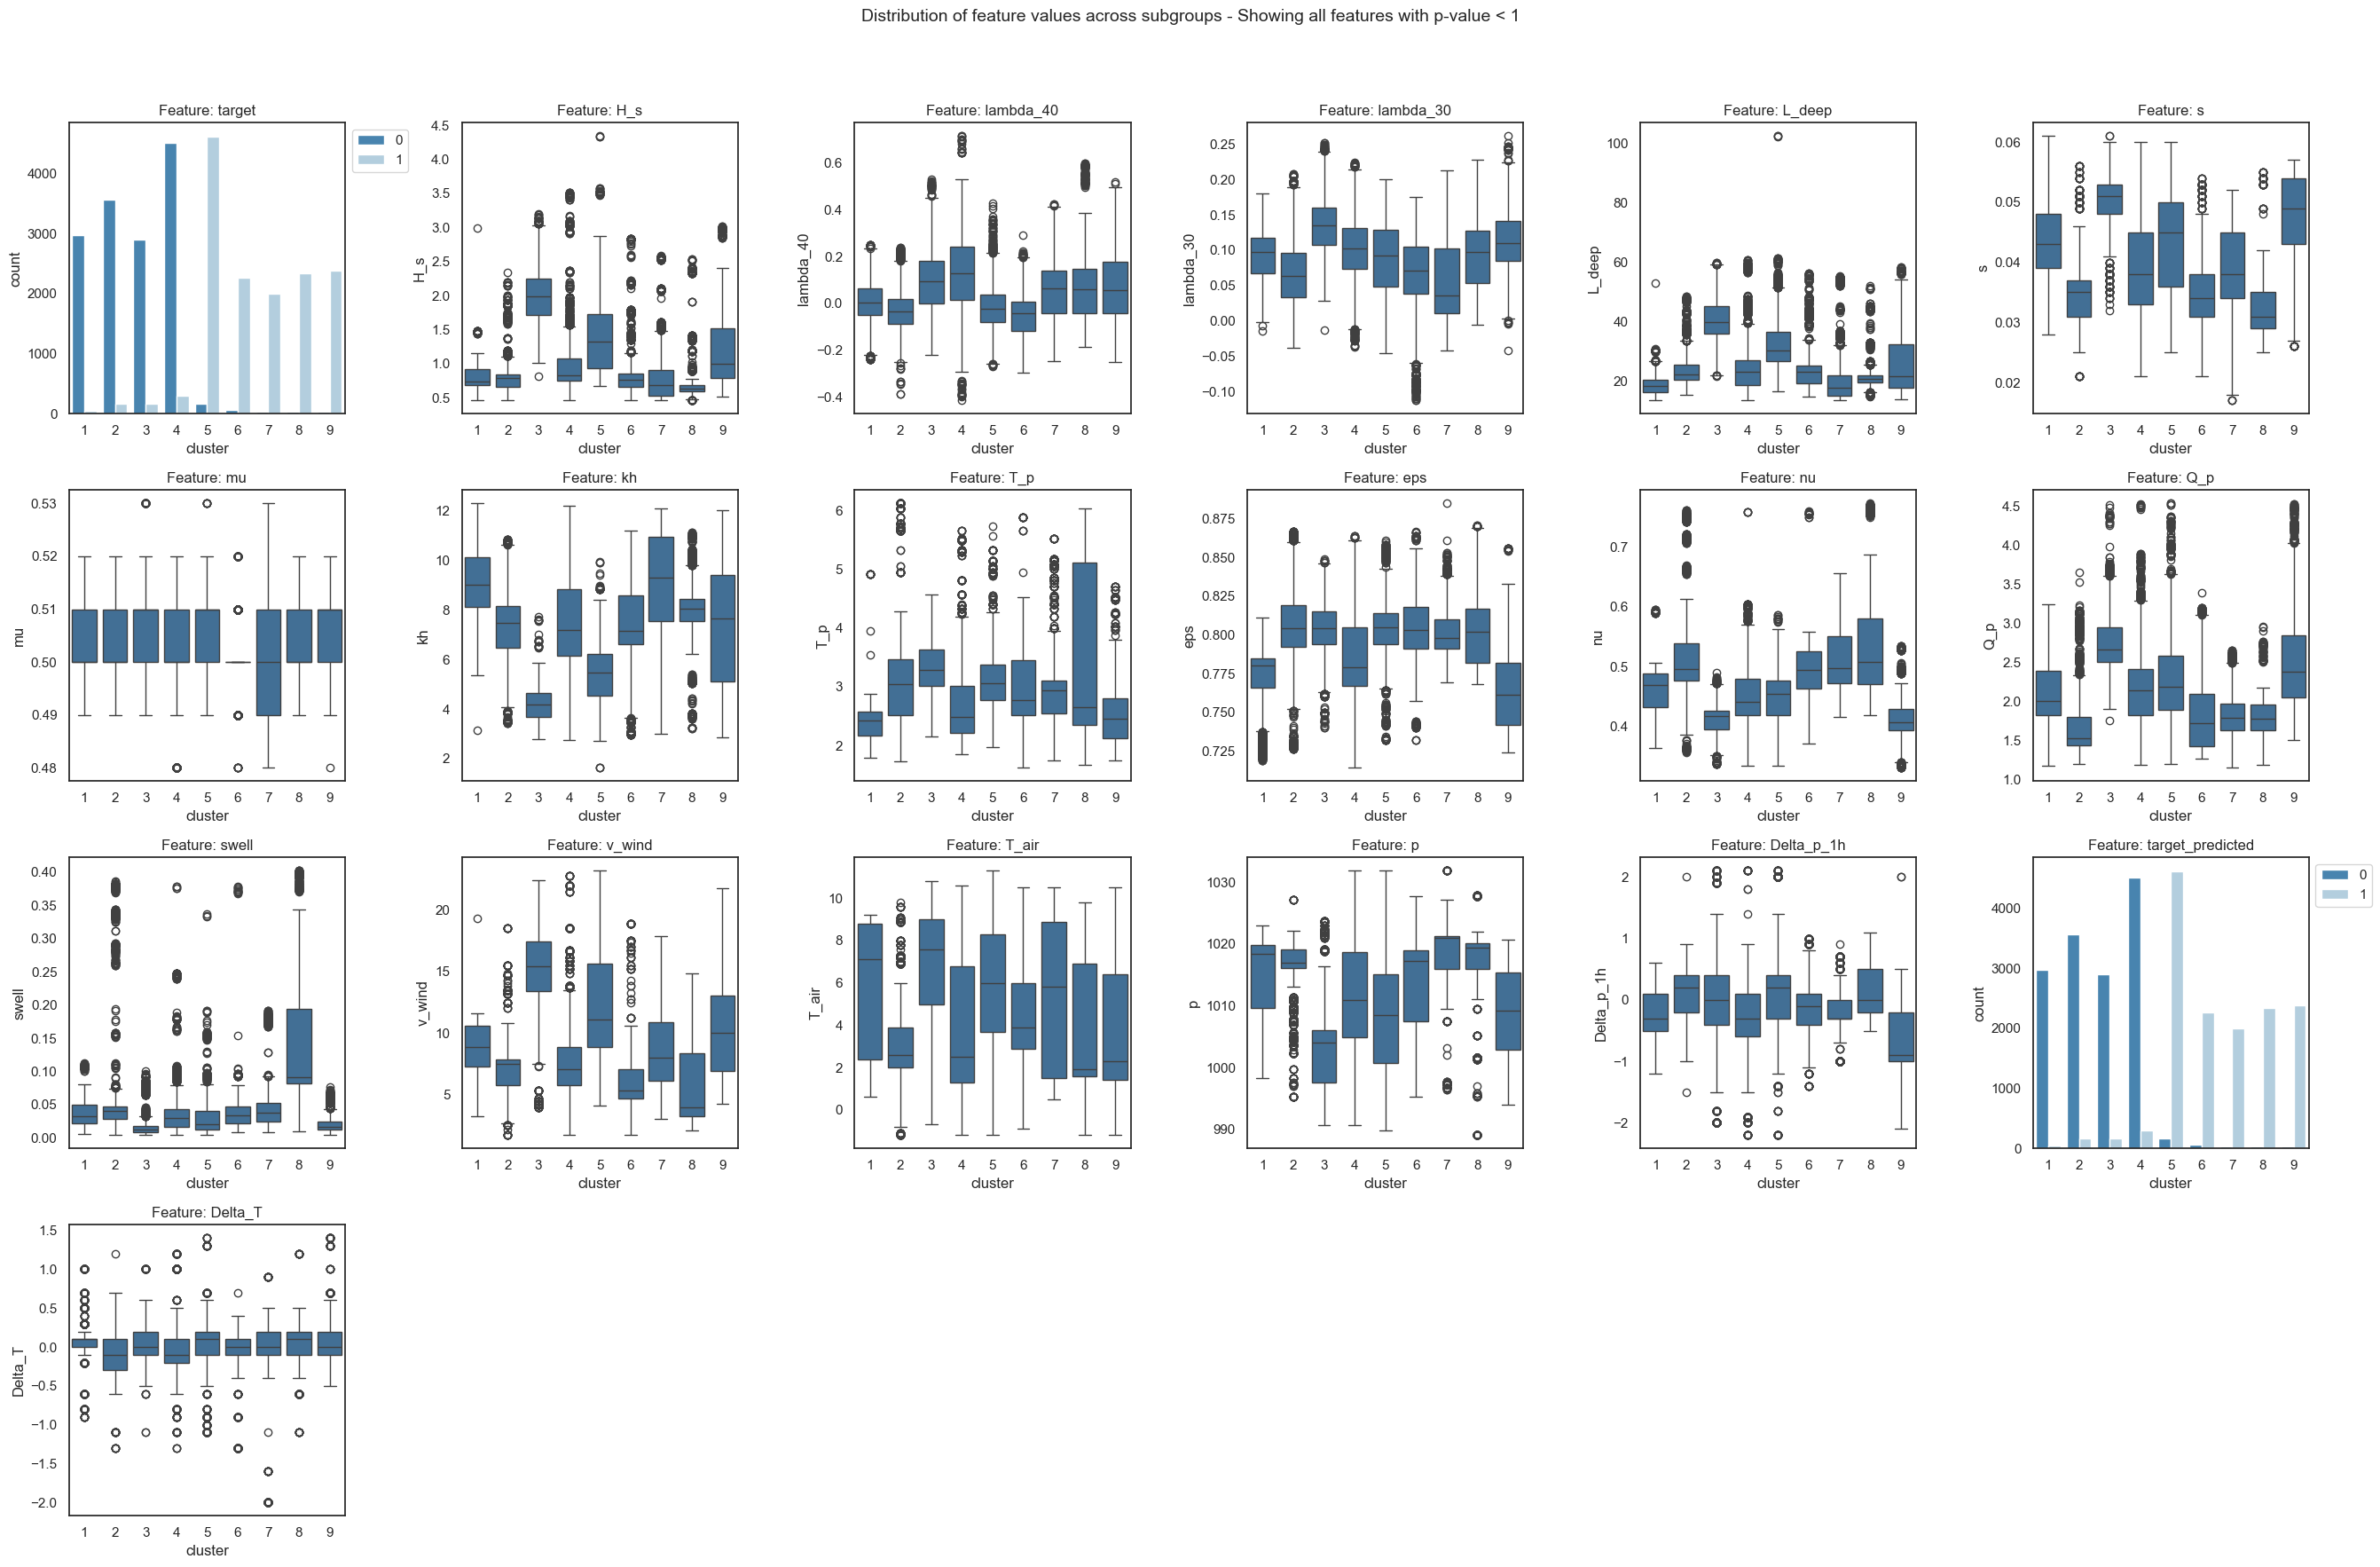

/Users/lisa.barros/anaconda3/envs/xai/lib/python3.11/site-packages/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


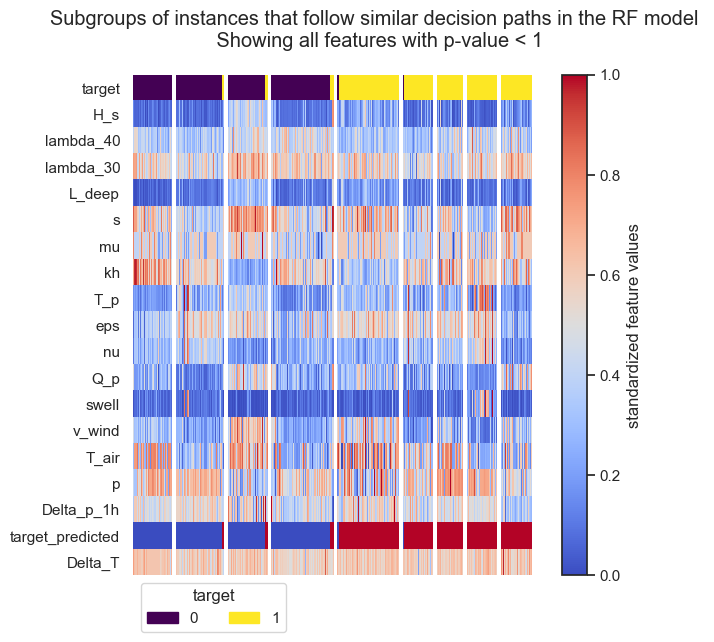

In [33]:
# create the fgc object
fgc = FgClustering(model=rf, data=data_fgc, target_column="target")

for k in [2,3,4,5,6,7,8,9]:
    fgc.run(number_of_clusters = k, method_clustering = 'pam', bootstraps_JI = 100, bootstraps_p_value = 100, discart_value_JI = 0.6 ,n_jobs = n_jobs, verbose = 2)

    data_fgc["target_predicted"] = rf.predict(X_train)
    fgc.calculate_statistics(data=data_fgc, target_column='target')

    fgc.plot_decision_paths()

Run FGC without subsampling

In [ ]:
# create the fgc object
fgc = FgClustering(model=rf, data=data_fgc, target_column="target")

fgc.run(
    max_K = 6, method_clustering = 'fasterpam', 
    bootstraps_JI = 50, bootstraps_p_value = 50, discart_value_JI = 0.6
    ,n_jobs = n_jobs, verbose = 2 
)

In [ ]:
fgc.plot_feature_importance()
fgc.plot_decision_paths()